In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
warnings.filterwarnings('ignore')

In [2]:
sp500 = pd.read_csv("./sp500.csv", index_col=0, parse_dates=True)

In [3]:
close = sp500.close.dropna()
close

date
1988-01-04     256.01
1988-01-05     258.77
1988-01-06     259.03
1988-01-07     261.21
1988-01-08     243.54
               ...   
2019-12-16    6470.03
2019-12-17    6472.24
2019-12-18    6470.00
2019-12-19    6499.26
2019-12-20    6531.75
Name: close, Length: 8062, dtype: float64

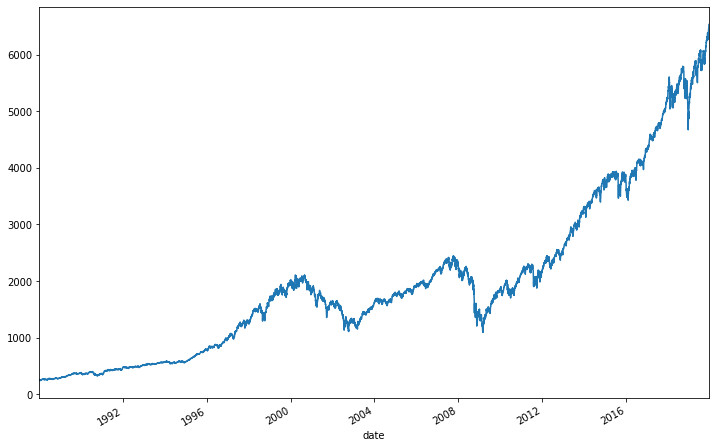

In [4]:
fig, ax = plt.subplots()
close.plot(ax=ax, figsize=(12,8))
plt.show()

In [5]:
close_adf = adfuller(close)
close_adf

(2.938131262462774,
 1.0,
 19,
 8042,
 {'1%': -3.4311634031982003,
  '5%': -2.861899466190631,
  '10%': -2.566961339130965},
 73094.11227987407)

In [6]:
close_1d = close.diff().dropna()
close_1dpc = (close.shift(1)/close).dropna()
close_log = np.log(close/close.shift(1)).dropna()

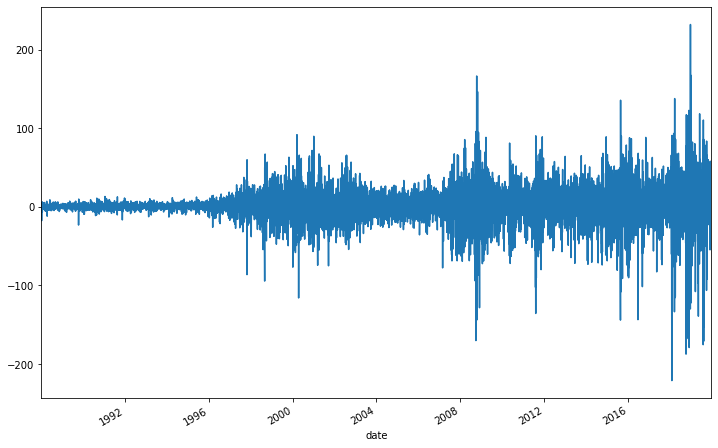

In [7]:
fig, ax = plt.subplots()
close_1d.plot(ax=ax, figsize=(12,8))
plt.show()

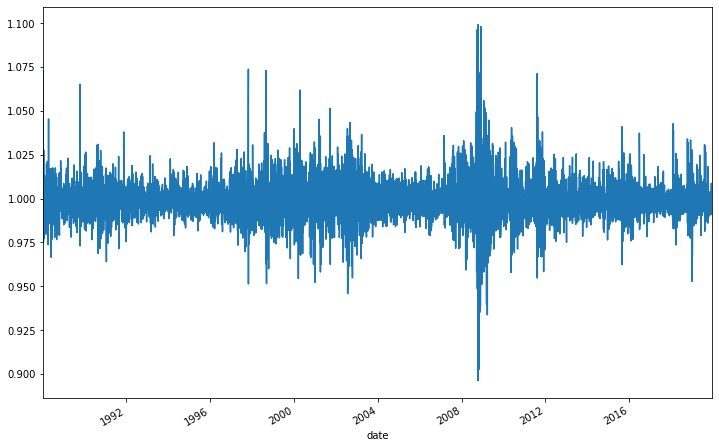

In [8]:
fig, ax = plt.subplots()
close_1dpc.plot(ax=ax, figsize=(12,8))
plt.show()

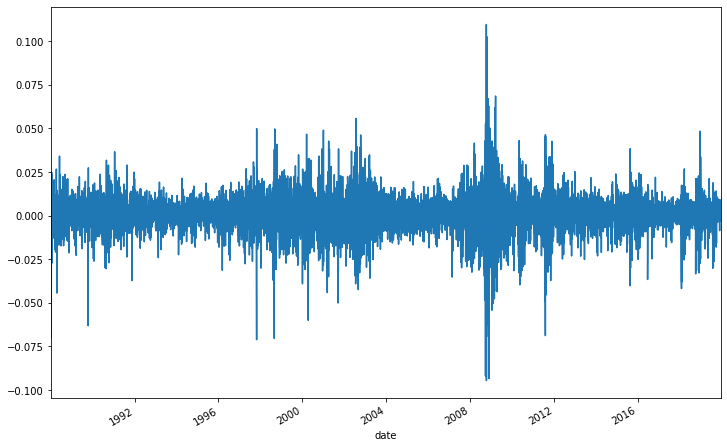

In [9]:
fig, ax = plt.subplots()
close_log.plot(ax=ax, figsize=(12,8))
plt.show()

In [10]:
close_1d_adf = adfuller(close_1d)
close_1dpc_adf = adfuller(close_1dpc)
close_log_adf = adfuller(close_log)

In [11]:
close_1d_adf

(-21.795194304871256,
 0.0,
 16,
 8044,
 {'1%': -3.4311632008951203,
  '5%': -2.8618993767993346,
  '10%': -2.566961291547038},
 73092.26380494033)

In [12]:
close_1dpc_adf

(-15.727124805501061,
 1.3027154788306872e-28,
 33,
 8027,
 {'1%': -3.4311649236856896,
  '5%': -2.861900138045498,
  '10%': -2.566961696766406},
 -49850.197032396325)

In [13]:
close_log_adf

(-16.042836440170497,
 5.888278553726929e-29,
 33,
 8027,
 {'1%': -3.4311649236856896,
  '5%': -2.861900138045498,
  '10%': -2.566961696766406},
 -49878.85358541975)

In [14]:
close_1d_arma_model = ARMA(close_1d, order=(1,1))
close_1d_arma_results = close_1d_arma_model.fit()

In [15]:
close_1d_arma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 8061
Model:                     ARMA(1, 1)   Log Likelihood              -36718.170
Method:                       css-mle   S.D. of innovations             23.014
Date:                Mon, 06 Jan 2020   AIC                          73444.340
Time:                        17:57:09   BIC                          73472.319
Sample:                             0   HQIC                         73453.913
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7771      0.217      3.580      0.000       0.352       1.203
ar.L1.close     0.7083      0.092      7.695      0.000       0.528       0.889
ma.L1.close    -0.7530      0.086     -8.766      0.000      -0.921      -0.585
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4119           +0.0000j            1.4119            0.0000
MA.1            1.3280           +0.0000j            1.3280            0.0000
-----------------------------------------------------------------------------
"""

## Generating ARMA Data

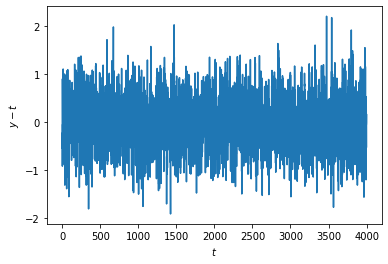

In [21]:
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(3)

# set the ARMA model coefficients
ar_coefs = [1, 0.2]
ma_coefs = [1, 0.3, 0.4]

# generate time-series data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=4000, sigma=0.5)

# plot the time-series
plt.plot(y)
plt.ylabel(r"$y-t$")
plt.xlabel(r"$t$")
plt.show()

In [22]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(y, order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4000
Model:                     ARMA(1, 2)   Log Likelihood               -2900.439
Method:                       css-mle   S.D. of innovations              0.500
Date:                Mon, 06 Jan 2020   AIC                           5810.878
Time:                        18:21:00   BIC                           5842.348
Sample:                             0   HQIC                          5822.033
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0205      0.011     -1.852      0.064      -0.042       0.001
ar.L1.y       -0.2488      0.036     -6.954      0.000      -0.319      -0.179
ma.L1.y        0.3291      0.033     10.077      0.000       0.265       0.393
ma.L2.y        0.4227      0.014     29.467      0.000       0.395       0.451
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.0186           +0.0000j            4.0186            0.5000
MA.1           -0.3893           -1.4880j            1.5381           -0.2907
MA.2           -0.3893           +1.4880j            1.5381            0.2907
-----------------------------------------------------------------------------
"""